## Cleaning

In [105]:
%run './lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


In [106]:
dfFlt  = load_df('dfFlt')
dfClean = dfFlt

### Remove unused variables

#### Remove unary learner_attempt_status = "fully scored"

In [107]:
dfClean = dfClean.drop('learner_attempt_status')

In [108]:
finish_todo('Remove unary learner_attempt_status = "fully scored"')

#### Remove variables assignment_late_submission, is_manual_scoring_required and is_deleted

In [109]:
dfClean = dfClean.drop('assignment_late_submission', 'is_manual_scoring_required', 'is_deleted')

In [110]:
finish_todo('Remove variables assignment_late_submission, is_manual_scoring_required and is_deleted')

#### Remove assignment_attempt_number and assignment_max_attempts

In [111]:
dfClean = dfClean.drop("assignment_attempt_number", "assignment_max_attempts")

In [112]:
finish_todo('Remove assignment_attempt_number and assignment_max_attempts')

#### Remove response_correctness variable

In [113]:
dfClean = dfClean.drop('response_correctness')

In [114]:
finish_todo('Remove response_correctness variable')

### Impute

#### Impute number_of_learners with calculated values
- Impute the full dateset with recalculated number_of_learners

In [115]:
dfClean = impute_number_of_learners(dfClean)

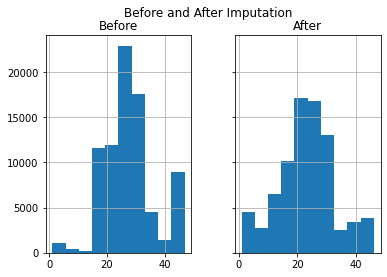

In [116]:
dual_hist(
    dfFlt.select('number_of_learners').toPandas(),
    dfClean.select('number_of_learners').toPandas(),
    title1='Before',
    title2='After',
    main='Before and After Imputation'
)

In [117]:
finish_todo("Impute number_of_learners with calculated values")

#### Impute 4446 of 18469 null dates in was_submitted_datetime_actual

In [118]:
dfClean = impute_4446_null_dates(dfClean)

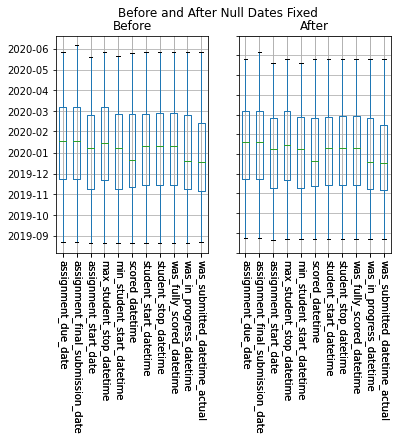

In [119]:
dual_date_boxplot(
    get_random_sample(dfFlt),
    get_random_sample(dfClean),
    title1='Before',
    title2='After',
    main='Before and After Null Dates Fixed'
)

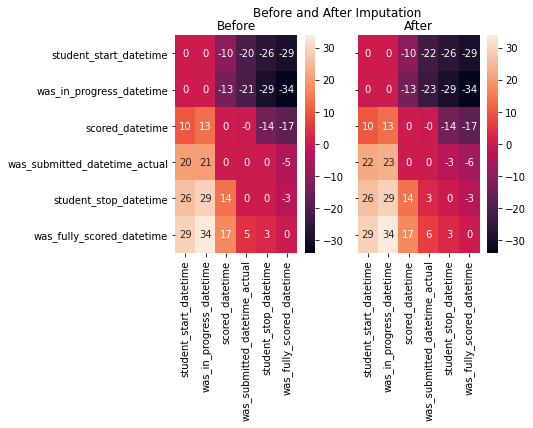

In [120]:
dual_mean_hours_assignment(
    get_random_sample(dfFlt),
    get_random_sample(dfClean),
    title1 = 'Before',
    title2 = 'After',
    main = 'Before and After Imputation'
)

Values corrected
- The corrected values adjusted the mean values of was_submited_datetime_actual up ~1 to 3 hours for related variables


In [121]:
finish_todo('Impute 4446 of 18469 null dates in was_submitted_datetime_actual')

#### Impute 749 t0 750 null dates
Impute null dates
   - in
      - student_start_datetime
      - student_stop_datetime
      - was_fully_scored_datetime

In [122]:
dfClean = impute_749_to_750_null_dates(dfClean)

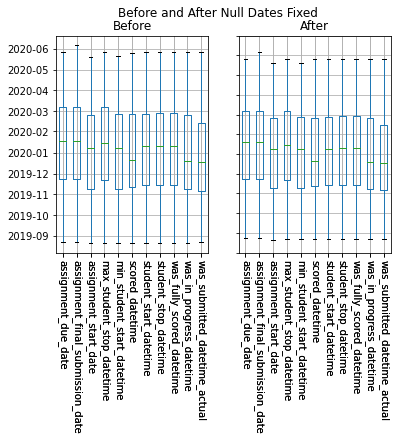

In [123]:
dual_date_boxplot(
    get_random_sample(dfFlt),
    get_random_sample(dfClean),
    title1='Before',
    title2='After',
    main='Before and After Null Dates Fixed'
)

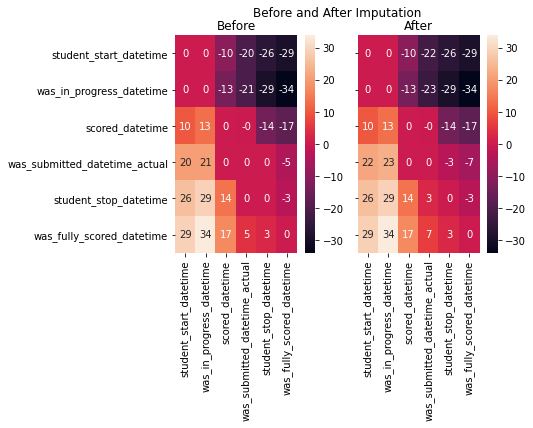

In [124]:
dual_mean_hours_assignment(
    get_random_sample(dfFlt),
    get_random_sample(dfClean),
    title1 = 'Before',
    title2 = 'After',
    main = 'Before and After Imputation'
)

Before and After Values Match
- student_start_datetime & scored_datetime = 9
- student_stop_datetime  & scored_datetime = -12
- was_fully_scored_datetime & scored_datetime = -17

In [125]:
finish_todo('Impute 749 t0 750 null dates')

#### Impute 3422 null dates in scored_datetime

In [126]:
dfClean = impute_3422_null_dates(dfClean)

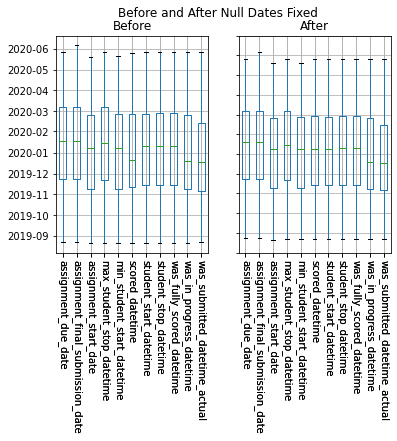

In [127]:
dual_date_boxplot(
    get_random_sample(dfFlt),
    get_random_sample(dfClean),
    title1='Before',
    title2='After',
    main='Before and After Null Dates Fixed'
)

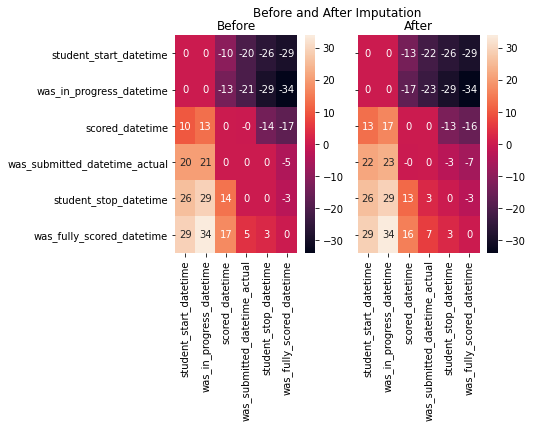

In [128]:
dual_mean_hours_assignment(
    get_random_sample(dfFlt),
    get_random_sample(dfClean),
    title1 = 'Before',
    title2 = 'After',
    main = 'Before and After Imputation'
)

Before and After Values Match
- student_stop_datetime  & scored_datetime = -12

In [129]:
finish_todo('Impute 3422 null dates in scored_datetime')

#### Impute 9965 null dates in was_in_progress_datetime

In [130]:
dfClean = impute_9965_null_dates(dfClean)

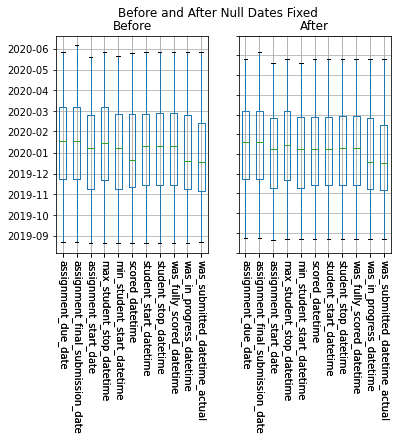

In [131]:
dual_date_boxplot(
    get_random_sample(dfFlt),
    get_random_sample(dfClean),
    title1='Before',
    title2='After',
    main='Before and After Null Dates Fixed'
)

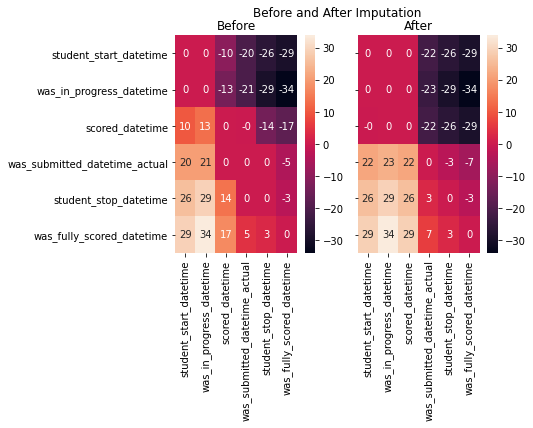

In [132]:
dual_mean_hours_assignment(
    get_random_sample(dfFlt),
    get_random_sample(dfClean),
    title1 = 'Before',
    title2 = 'After',
    main = 'Before and After Imputation'
)

Before and After Values Match
- student_start_datetime  & was_in_progress_datetime = -12

In [133]:
finish_todo('Impute 9965 null dates in was_in_progress_datetime')


#### Reduce number of levels in item_type_code_name

###### Categories before

In [134]:
# Before Categories
dfClean.select("item_type_code_name").distinct().orderBy("item_type_code_name").show(50, False)


+----------------------+
|item_type_code_name   |
+----------------------+
|null                  |
|FillinBlankResponse   |
|MultipleChoiceResponse|
|RubricResponse        |
|aheAlgo               |
|bucketing             |
|choiceMatrix          |
|cloze                 |
|equationEntry         |
|essay                 |
|fileUpload            |
|fillInTheBlank        |
|graphing              |
|imageLabel            |
|matching              |
|multipleChoice        |
|multipleSelect        |
|numberLine            |
|selectText            |
|shortAnswer           |
|sortable              |
|trueFalse             |
+----------------------+



In [135]:
dfClean = reduce_type_code_levels(dfClean)

###### Categories after

In [136]:
# Display new values
dfClean.groupBy("item_type_code_name").count().orderBy("count", ascending=False).show(50, False)

+-------------------+-----+
|item_type_code_name|count|
+-------------------+-----+
|multipleChoice     |34001|
|Other              |19991|
|fillInTheBlank     |12077|
|equationEntry      |9516 |
|trueFalse          |4963 |
+-------------------+-----+



In [137]:
finish_todo('Reduce number of levels in item_type_code_name')


In [138]:
save_df(dfClean, 'dfClean')

{'todo': 'Investigate 15710 null assessment_item_response_id', 'finished': True}
{'todo': 'Investigate 3298 null values in response_correctness', 'finished': True}
{'todo': 'Investigate 1566 [unassigned] in response_correctness', 'finished': True}
{'todo': 'Investigate null values in item_type_code_name', 'finished': True}
{'todo': 'Reduce number of levels in item_type_code_name', 'finished': True}
{'todo': 'Remove unary learner_attempt_status = "fully scored"', 'finished': True}
{'todo': 'Investigate number_of_learners > 40 outliers', 'finished': True}
{'todo': 'Investigate binary variables assignment_attempt_number and assignment_max_attempts', 'finished': True}
{'todo': 'Investigate assignment_attempt_number and assignment_max_attempts both have 1566 values', 'finished': True}
{'todo': 'Investigate final_score_unweighted has 16,582 zero values', 'finished': True}
{'todo': 'Investigate 1566 null dates', 'finished': True}
{'todo': 'Investigate 749 t0 750 null dates', 'finished': True}